In [220]:
import numpy as np
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer , TreebankWordTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score, accuracy_score , recall_score , precision_score
import pickle
from nltk.tokenize import word_tokenize, PunktSentenceTokenizer, TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer


In [195]:
df_all = pd.read_pickle('data/all_data.pkl')
#Do this once, only when your data is changed 
# df_train = df_all.sample(frac=0.7)
# df_test = df_all.loc[~df_all.index.isin(df_train.index), :]
# #pickle these for grid search
# df_train.to_pickle('data/data_train.pkl')
# df_test.to_pickle('data/data_test.pkl')

In [196]:
df_all.head(2)

,content,id,label,media-type,published,source,title
0,(Before It's News) \n\nBEA Revises 2nd Quarte...,09418d4b-e5fa-4273-84d7-a3ea43a78f4d,1,News,2015-09-26T01:44:30Z,Before It's News,BEA Deflates GDP Higher
1,Obama reportedly eager to assist. TEHRAN (FNA)...,bf6d6b0e-584b-4ea9-aad7-f669f95cde6c,1,Blog,2015-09-04T13:25:11Z,Weasel Zippers,Iranian Commander Vows To Continue Weapons Bui...


In [197]:
len(df_all)

7852

In [198]:
df_train = pd.read_pickle('data/data_train.pkl')
df_test = pd.read_pickle('data/data_test.pkl')

In [199]:
df_train.groupby('label').count()

,content,id,media-type,published,source,title
label,,,,,,
0,3255,3255,3255,3255,3255,3255
1,2241,2241,2241,2241,2241,2241


In [200]:
df_test.groupby('label').count()

,content,id,media-type,published,source,title
label,,,,,,
0,1385,1385,1385,1385,1385,1385
1,971,971,971,971,971,971


In [201]:
#change above X if we r using tokenize and other nlp process
X_train = df_train['content']
y_train = df_train['label']
X_test = df_test['content']
y_test = df_test['label']

In [202]:
# tfidf_vectorizer  = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1,2), max_df= 0.85, min_df= 2)

# #takes around 2-3 mins
# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [225]:
#load Xtrain_tfidf from stored pickle
with open('data/X_train_tfidf.pkl', 'rb') as input:
    X_train_tfidf = pickle.load(input)
    
with open('data/X_test_tfidf.pkl', 'rb') as input:
    X_test_tfidf = pickle.load(input)
    
with open('data/y_train_spacy.pkl', 'rb') as input:
    y_train = pickle.load(input)
    
with open('data/y_test_spacy.pkl', 'rb') as input:
    y_test = pickle.load(input)

### Create Confusion Matrix

In [281]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_confusion_matrix(y_pred, y_true):
    '''Code stolen brazenly from sklearn example.'''
    cm = confusion_matrix(y_true, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, cmap = plt.get_cmap('Blues'), annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_ylabel('Predicted labels');ax.set_xlabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Fake', 'Real']); ax.yaxis.set_ticklabels(['Fake', 'Real']);


In [228]:
def print_model_scores(y_actual, y_predicted, model_name):
    accuracy = accuracy_score(y_actual, y_predicted) *  100 
    f1 = f1_score(y_actual, y_predicted) * 100
    precision = precision_score(y_actual, y_predicted) * 100
    recall = recall_score(y_actual, y_predicted) * 100
    print ("{} accuracy and F1 score \n".format(model_name))
    print ("Accuracy {:.5}".format(accuracy))
    print ("F1 {:.5}".format(f1))
    print ("Precision {:.5}".format(precision))
    print ("Recall {:.5}".format(recall))
    
    

## Modeling

### Naive Bayes

In [226]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb = nb.fit(X_train_tfidf, y_train)
y_test_predict_nb = nb.predict(X_test_tfidf)

In [229]:
print_model_scores(y_test, y_test_predict_nb, "Naive Bayes")

Naive Bayes accuracy and F1 score 

Accuracy 81.971
F1 73.997
Precision 70.672
Recall 77.651


### Logistic Regression

In [231]:
# using optimal parameters from grid search (l1 and 10)
lr = LogisticRegression(penalty='l1', C = 10)
lr.fit(X_train_tfidf, y_train)
y_test_predict_lr = lr.predict(X_test_tfidf)

In [249]:
print_model_scores(y_test, y_test_predict_lr, "Logistic regression")

Logistic regression accuracy and F1 score 

Accuracy 89.32
F1 83.692
Precision 84.444
Recall 82.952


In [241]:
coeff = lr.coef_[0]
coeff.shape

(5000,)

In [242]:
top_n_index = np.argsort(coeff)[::-1][:20]
print(top_n_index)
with open('data/tfidf_featurenames_spacy.pkl', 'rb') as input:
    featurenames_spacy = pickle.load(input)

    #feature_names = tfidf_vectorizer.get_feature_names()
top_feat_tuple = [(featurenames_spacy[i], coeff[i]) for i in top_n_index]

print(top_feat_tuple)

array([2091, 4408, 3426,  274,  235, 3132, 1407,  346, 4974, 3425,  494,
        658, 4843,  967, 4279, 1485, 4692,  974, 3702, 1684])

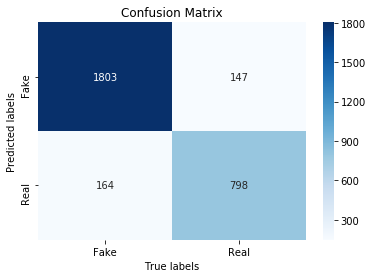

In [282]:
plot_confusion_matrix(y_test_predict_lr, y_test)


### Random Forest

In [247]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50,min_samples_split=5, max_depth=60)
rf.fit(X_train_tfidf, y_train)
y_test_predict_rf = rf.predict(X_test_tfidf)

In [252]:
print_model_scores(y_test, y_test_predict_rf, "Random Forest")

Random Forest accuracy and F1 score 

Accuracy 89.389
F1 82.956
Precision 88.367
Recall 78.17


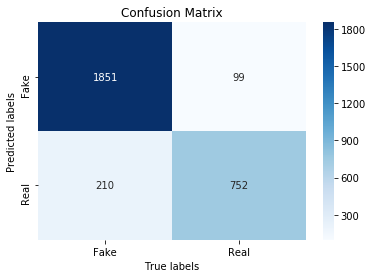

In [283]:
plot_confusion_matrix(y_test_predict_rf, y_test)

### SVM classifier

In [259]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear', probability = True, random_state = 0)

In [260]:
#6.49 -> 7.38
svm.fit(X_train_tfidf, y_train)
y_test_predict_svm = svm.predict(X_test_tfidf)

In [261]:
print_model_scores(y_test, y_test_predict_svm, "SVM")

SVM accuracy and F1 score 

Accuracy 88.908
F1 82.474
Precision 86.266
Recall 79.002


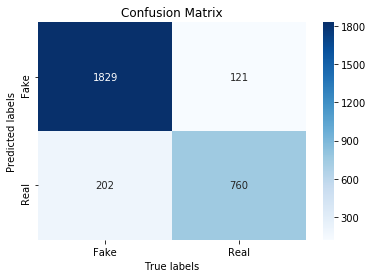

In [284]:
plot_confusion_matrix(y_test_predict_svm, y_test)

### Boosting using Adaboost

In [257]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(algorithm = "SAMME.R", n_estimators = 50)
ada.fit(X_train_tfidf, y_train)
y_test_predict_ada = ada.predict(X_test_tfidf)

In [258]:
print_model_scores(y_test, y_test_predict_ada, "AdaBoost")

AdaBoost accuracy and F1 score 

Accuracy 87.054
F1 80.736
Precision 79.397
Recall 82.121


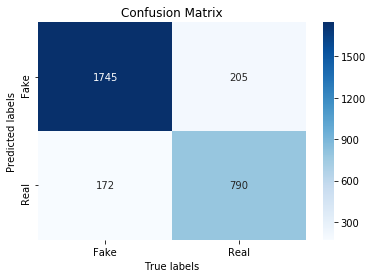

In [285]:
plot_confusion_matrix(y_test_predict_ada, y_test)

### Lets plot ROC curve for various models

In [286]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as skm
from sklearn.metrics import roc_curve, roc_auc_score
%matplotlib inline

In [287]:
# First calculate predicted probabilities for all the models
nb_probs = nb.predict_proba(X_test_tfidf)[:, 1]
lr_probs = lr.predict_proba(X_test_tfidf)[:, 1]
rf_probs = rf.predict_proba(X_test_tfidf)[:, 1]
ada_probs = ada.predict_proba(X_test_tfidf)[:, 1]
svm_probs = svm.predict_proba(X_test_tfidf)[:, 1]

#fpr, tpr, threshold = roc_curve(y_test, preds)
fpr_nb, tpr_nb, thresholds_nb = skm.roc_curve(y_test, nb_probs)
fpr_lr, tpr_lr, thresholds_lr = skm.roc_curve(y_test, lr_probs)
fpr_rf, tpr_rf, thresholds_rf = skm.roc_curve(y_test, rf_probs)
fpr_ada, tpr_ada, thresholds_ada = skm.roc_curve(y_test, ada_probs)
fpr_svm, tpr_svm, thresholds_svm = skm.roc_curve(y_test, svm_probs)

In [289]:
import sklearn.metrics as skm
roc_auc_nb = skm.roc_auc_score(y_test, y_test_predict_nb)
roc_auc_lr = skm.roc_auc_score(y_test, y_test_predict_lr)
roc_auc_rf = skm.roc_auc_score(y_test, y_test_predict_rf)
roc_auc_ada = skm.roc_auc_score(y_test, y_test_predict_ada)
roc_auc_svm = skm.roc_auc_score(y_test, y_test_predict_svm)

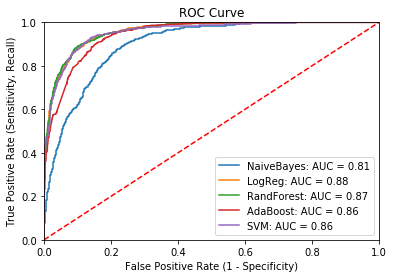

In [293]:
#Now plot these values
plt.title('ROC Curve')
plt.plot(fpr_nb, tpr_nb, label = 'NaiveBayes: AUC = %0.2f' % roc_auc_nb)
plt.plot(fpr_lr, tpr_lr, label = 'LogReg: AUC = %0.2f' % roc_auc_lr)
plt.plot(fpr_rf, tpr_rf, label = 'RandForest: AUC = %0.2f' % roc_auc_rf)
plt.plot(fpr_ada, tpr_ada, label = 'AdaBoost: AUC = %0.2f' % roc_auc_ada)
plt.plot(fpr_svm, tpr_svm, label = 'SVM: AUC = %0.2f' % roc_auc_svm)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.show()